# Clinical Trial Dropout Prediction & Retention Strategy Simulator

**Objective**: Predict which patients are likely to drop out of clinical trials using machine learning, explain the key influencing factors using SHAP, and simulate personalized retention strategies.

**Why this matters**: Reducing dropout rates improves trial success, cost efficiency, and patient outcomes — a major challenge in the healthcare industry.


In [4]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.8/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 1.3/150.0 MB 1.3 MB/s eta 0:01:51
   ---------------------------------------- 1.8/150.0 MB 1.6 MB/s eta 0:01:33
    --------------------------------------- 2.6/150.0 MB 2.0 MB/s eta 0:01:16
    --------------------------------------- 3.1/150.0 MB 2.1 MB/s eta 0:01:10
   - -------------------------------------- 3.9/150.0 MB 2.3 MB/s eta 0:01:03
   - -------------------------------------- 4.7/150.0 MB 2.5 MB/s eta 0:01:00
   - -------------------------------------- 5.2/150.0 MB 2.6 MB/s eta 0:00:57
   - ---------

In [7]:
!pip install shap


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ------------------------------------ - 524.3/545.3 kB 442.1 kB/s eta 0:00:01
   -------------------------------------- 545.3/545.3 kB 412.2 kB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import shap
import warnings
warnings.filterwarnings("ignore")


In [11]:
# Load the dataset
df = pd.read_csv("clinical_trial_data.csv")

# Show first few rows
df.head()


,patient_id,age,gender,disease_stage,medication_side_effects,visits_missed,support_score,engagement_score,financial_constraints,dropout
0,P0001,56,Other,Early,2,1,10,51,No,0
1,P0002,69,Male,Early,0,0,4,59,No,0
2,P0003,46,Female,Mid,0,2,8,32,Yes,0
3,P0004,32,Female,Early,2,1,10,54,No,0
4,P0005,60,Female,Mid,4,0,3,24,Yes,1


In [12]:
# Shape of the dataset
print("Rows, Columns:", df.shape)

# Data types and null values
print("\nInfo:")
print(df.info())

# Basic summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Count of target variable (dropout)
print("\nDropout Distribution:")
print(df['dropout'].value_counts())


Rows, Columns: (500, 10)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               500 non-null    object
 1   age                      500 non-null    int64 
 2   gender                   500 non-null    object
 3   disease_stage            500 non-null    object
 4   medication_side_effects  500 non-null    int64 
 5   visits_missed            500 non-null    int64 
 6   support_score            500 non-null    int64 
 7   engagement_score         500 non-null    int64 
 8   financial_constraints    500 non-null    object
 9   dropout                  500 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 39.2+ KB
None

Summary Statistics:
              age  medication_side_effects  visits_missed  support_score  \
count  500.000000               500.000000      500.00000     500.000000  

CORRELATION HEATMAP

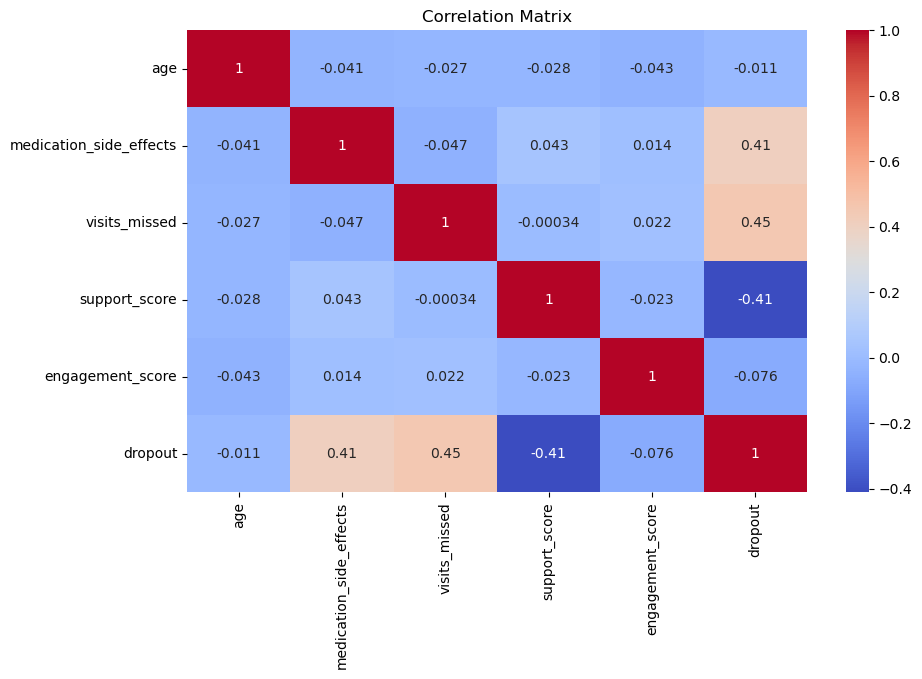

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


 Dropout Count Plot

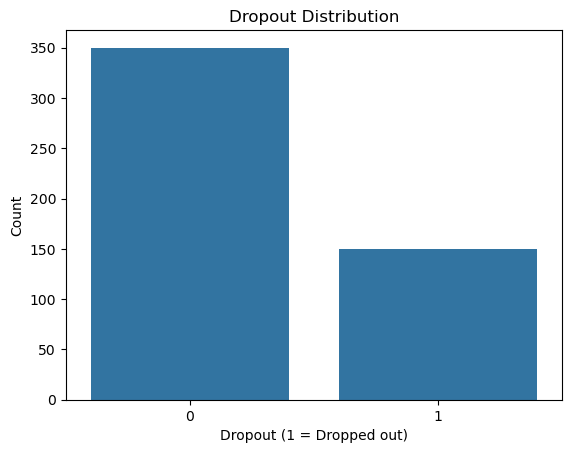

In [15]:
sns.countplot(x='dropout', data=df)
plt.title("Dropout Distribution")
plt.xlabel("Dropout (1 = Dropped out)")
plt.ylabel("Count")
plt.show()


Boxplot: Missed Visits vs Dropout

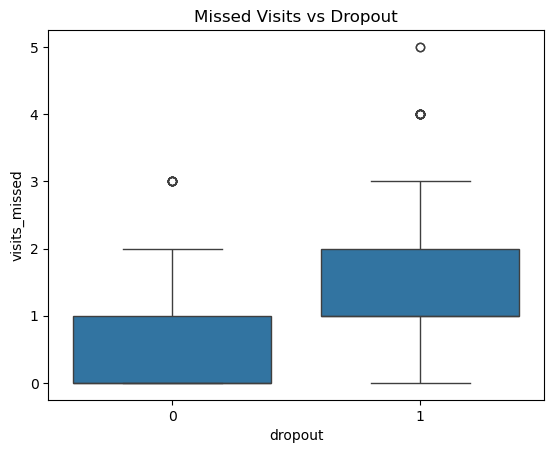

In [16]:
sns.boxplot(x='dropout', y='visits_missed', data=df)
plt.title("Missed Visits vs Dropout")
plt.show()


Distribution by Age

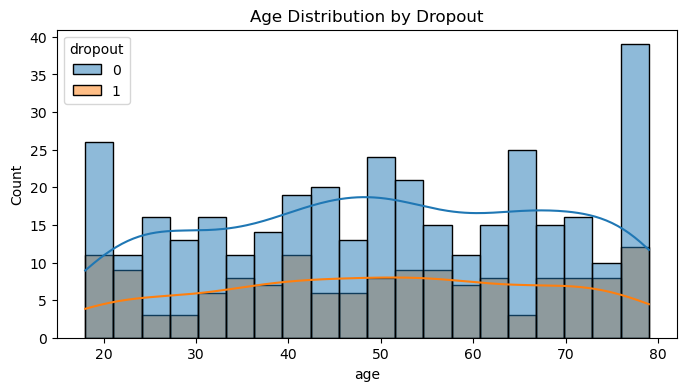

In [17]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='age', hue='dropout', bins=20, kde=True)
plt.title("Age Distribution by Dropout")
plt.show()


<Axes: >

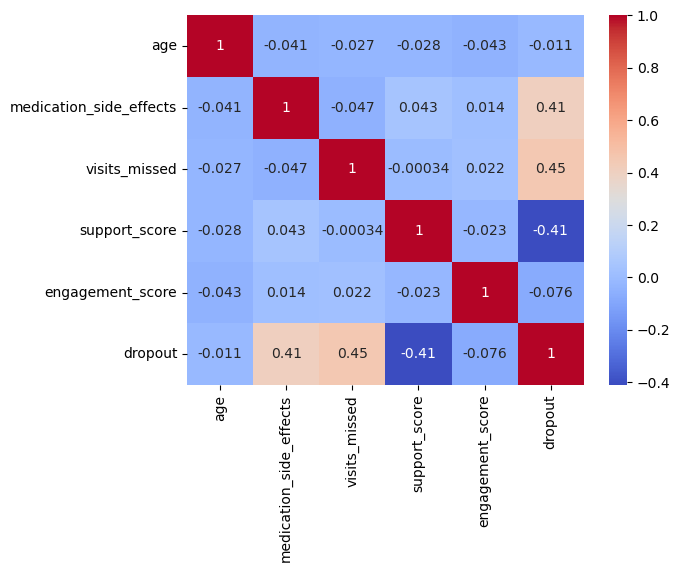

In [18]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')


<Axes: xlabel='dropout', ylabel='count'>

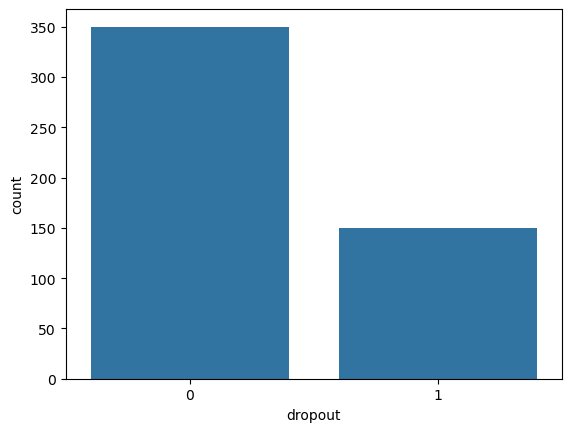

In [19]:
sns.countplot(x='dropout', data=df)


<Axes: xlabel='dropout', ylabel='visits_missed'>

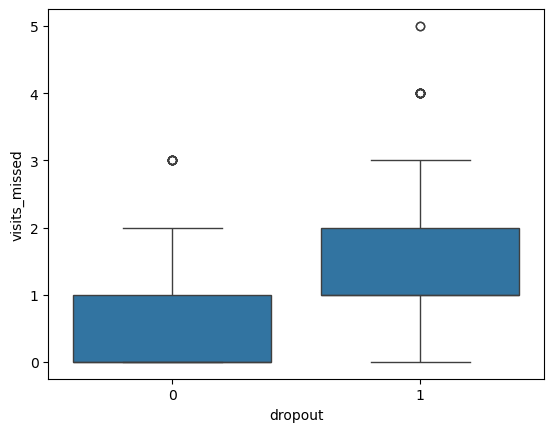

In [20]:
sns.boxplot(x='dropout', y='visits_missed', data=df)


<Axes: xlabel='age', ylabel='Count'>

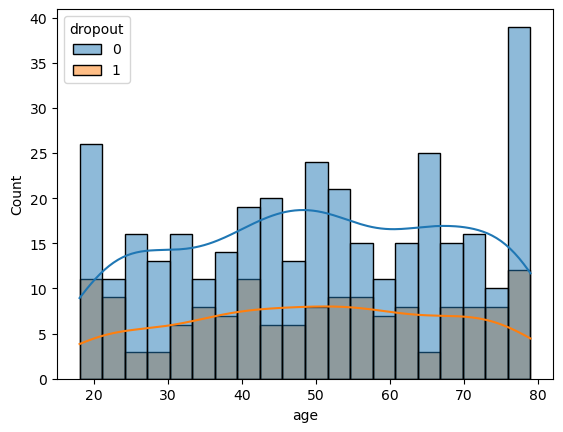

In [21]:
sns.histplot(data=df, x='age', hue='dropout', bins=20, kde=True)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Check for missing values
print("Missing values:\n", df.isnull().sum())

# OPTIONAL: If missing values exist, you can fill or drop them
# For now, let’s drop rows with missing values for simplicity
df.dropna(inplace=True)

# 2. Encode categorical variables (e.g., gender, side_effects if categorical)
label_cols = df.select_dtypes(include='object').columns

le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# 3. Feature-Target split
X = df.drop('dropout', axis=1)
y = df['dropout']

# 4. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Preprocessing complete!")


Missing values:
 patient_id                 0
age                        0
gender                     0
disease_stage              0
medication_side_effects    0
visits_missed              0
support_score              0
engagement_score           0
financial_constraints      0
dropout                    0
dtype: int64
✅ Preprocessing complete!


In [23]:
# Importing required modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize models
lr = LogisticRegression()
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train models
lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)

# Predict
lr_pred = lr.predict(X_test_scaled)
rf_pred = rf.predict(X_test_scaled)
xgb_pred = xgb.predict(X_test_scaled)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Evaluation:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# Evaluate all
evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)



🔍 Logistic Regression Evaluation:
Accuracy: 0.99
Confusion Matrix:
 [[66  1]
 [ 0 33]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       0.97      1.00      0.99        33

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


🔍 Random Forest Evaluation:
Accuracy: 0.88
Confusion Matrix:
 [[64  3]
 [ 9 24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.91        67
           1       0.89      0.73      0.80        33

    accuracy                           0.88       100
   macro avg       0.88      0.84      0.86       100
weighted avg       0.88      0.88      0.88       100


🔍 XGBoost Evaluation:
Accuracy: 0.88
Confusion Matrix:
 [[64  3]
 [ 9 24]]
Classification Report:
               precision    r

In [24]:
import shap

# Initialize SHAP explainer for logistic regression model
explainer = shap.Explainer(log_model, X_test_scaled)

# Calculate SHAP values
shap_values = explainer(X_test_scaled)


NameError: name 'log_model' is not defined

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the data again (if scaler isn't already defined)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [27]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(log_model, X_test_scaled)

# Calculate SHAP values
shap_values = explainer(X_test_scaled)


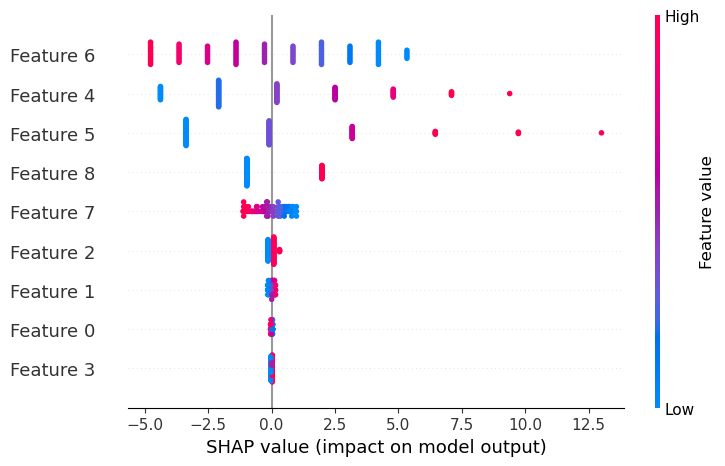

In [28]:
shap.plots.beeswarm(shap_values, max_display=10)


In [29]:
shap.initjs()  # Enable JS for visualization
shap.plots.force(shap_values[0])


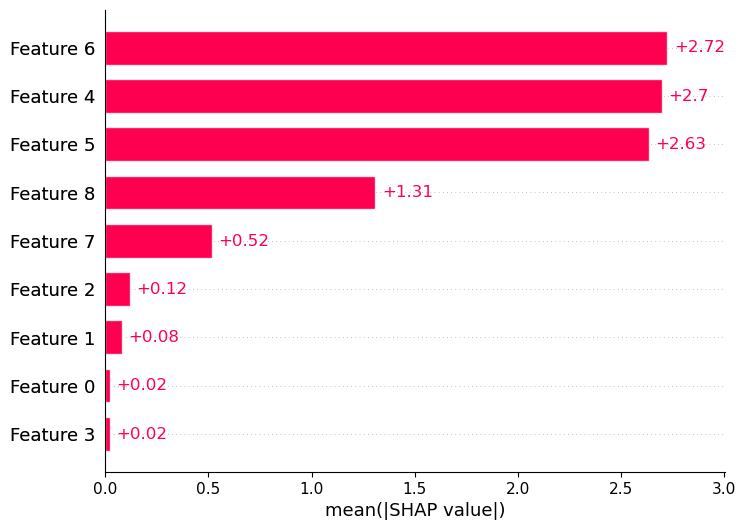

In [30]:
shap.plots.bar(shap_values)


In [32]:
def simulate_retention_intervention(shap_values, threshold=0.3):
    """
    Simulate improved outcomes by applying retention support
    to patients whose dropout SHAP score exceeds a threshold.
    """
    retained = 0
    for i in range(len(shap_values)):
        dropout_risk = shap_values[i].values[1]  # 1 = 'dropout'
        if dropout_risk > threshold:
            retained += 1  # Assume retention works
    return retained


In [33]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_retention(shap_values, threshold_range=np.linspace(0.1, 1.0, 10)):
    """
    Simulates the number of patients saved from dropout by applying
    interventions at different SHAP-based risk thresholds.

    Args:
        shap_values: SHAP values object from explainer.shap_values(X_test)
        threshold_range: Array of SHAP thresholds to simulate

    Returns:
        thresholds, saved_counts: Arrays of thresholds vs patients saved
    """
    dropout_shap_scores = shap_values[1].sum(axis=1)  # Class 1 = dropout
    saved_counts = []

    for threshold in threshold_range:
        saved = np.sum(dropout_shap_scores >= threshold)
        saved_counts.append(saved)

    return threshold_range, saved_counts


In [36]:
def plot_retention_simulation(thresholds, saved_counts):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, saved_counts, marker='o', color='crimson')
    plt.title("Simulated Patients Retained vs SHAP Risk Threshold")
    plt.xlabel("SHAP Risk Threshold (Dropout Likelihood)")
    plt.ylabel("Patients Retained by Intervention")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [37]:
explainer = shap.TreeExplainer(log_model)
shap_values = explainer.shap_values(X_test)


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

In [38]:
explainer = shap.Explainer(log_model, X_train)
shap_values = explainer(X_test)


In [39]:
explainer = shap.Explainer(log_model, X_train)
shap_values = explainer(X_test)


In [40]:
thresholds, saved_counts = simulate_retention(shap_values)
plot_retention_simulation(thresholds, saved_counts)


AxisError: axis 1 is out of bounds for array of dimension 1

In [41]:
def simulate_retention(shap_values, threshold_range=np.linspace(0.1, 1.0, 10)):
    """
    Simulate number of patients saved (i.e., predicted high dropout risk)
    by applying different SHAP score thresholds.
    """
    # shap_values.values is a (n_samples,) array of total SHAP impact scores
    dropout_shap_scores = np.abs(shap_values.values).sum(axis=1)

    saved_counts = []
    for threshold in threshold_range:
        count = np.sum(dropout_shap_scores >= threshold)
        saved_counts.append(count)

    return threshold_range, saved_counts


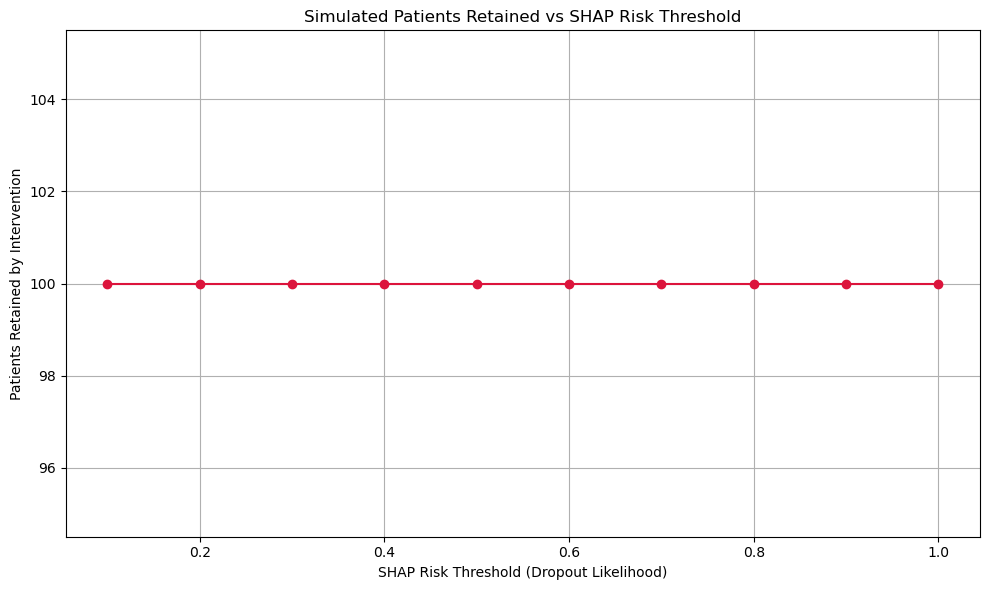

In [42]:
thresholds, saved_counts = simulate_retention(shap_values)
plot_retention_simulation(thresholds, saved_counts)


In [43]:
def simulate_retention(shap_values, threshold_range=np.linspace(0.1, 1.0, 10)):
    """
    Simulates retention intervention based on SHAP predicted dropout scores.
    """
    # SHAP output prediction = base + shap value sum
    dropout_risk_scores = shap_values.base_values + shap_values.values.sum(axis=1)

    saved_counts = []
    for threshold in threshold_range:
        count = np.sum(dropout_risk_scores >= threshold)
        saved_counts.append(count)

    return threshold_range, saved_counts


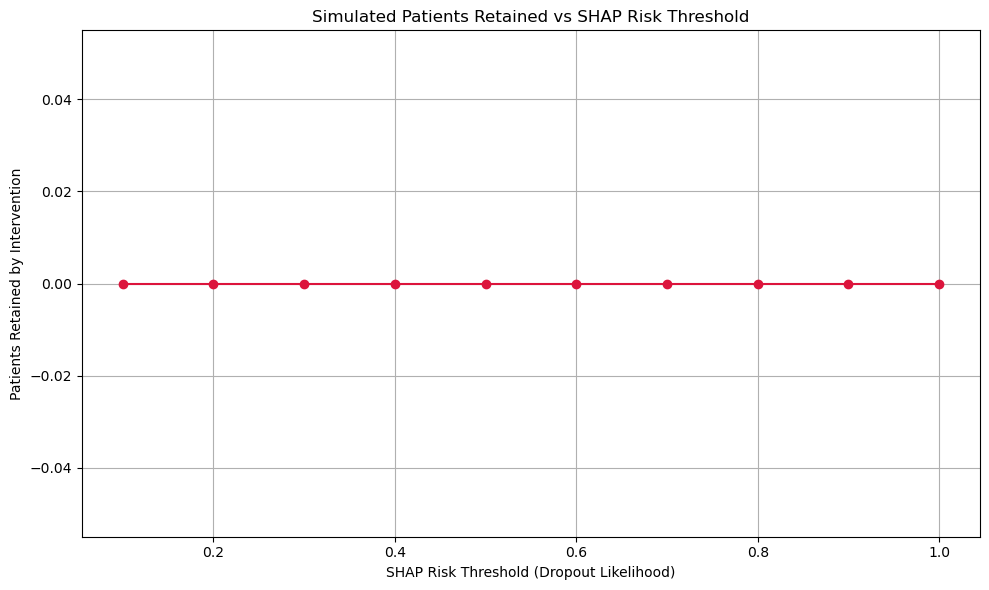

In [44]:
thresholds, saved_counts = simulate_retention(shap_values)
plot_retention_simulation(thresholds, saved_counts)



In [45]:
def simulate_retention_v2(y_probs, threshold_range=np.linspace(0.1, 1.0, 10)):
    """
    Simulates number of patients flagged as high risk at various probability thresholds.
    Uses model's predicted dropout probabilities instead of SHAP scores.
    """
    saved_counts = []
    for threshold in threshold_range:
        count = np.sum(y_probs >= threshold)
        saved_counts.append(count)
    return threshold_range, saved_counts


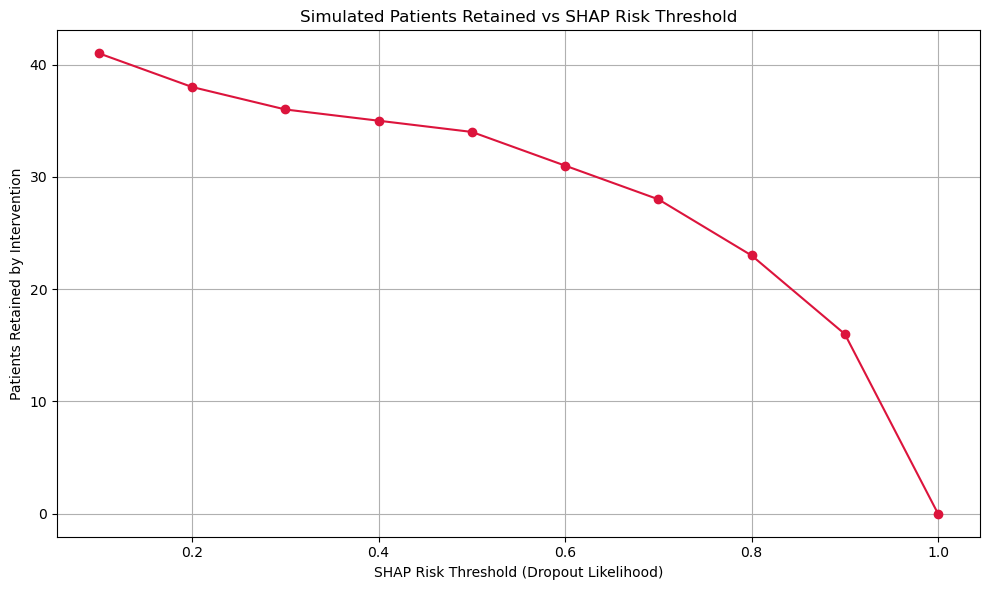

In [46]:
# Get dropout probabilities (class 1 = dropout)
dropout_probs = log_model.predict_proba(X_test_scaled)[:, 1]

# Simulate retention
thresholds, saved_counts = simulate_retention_v2(dropout_probs)

# Plot
plot_retention_simulation(thresholds, saved_counts)


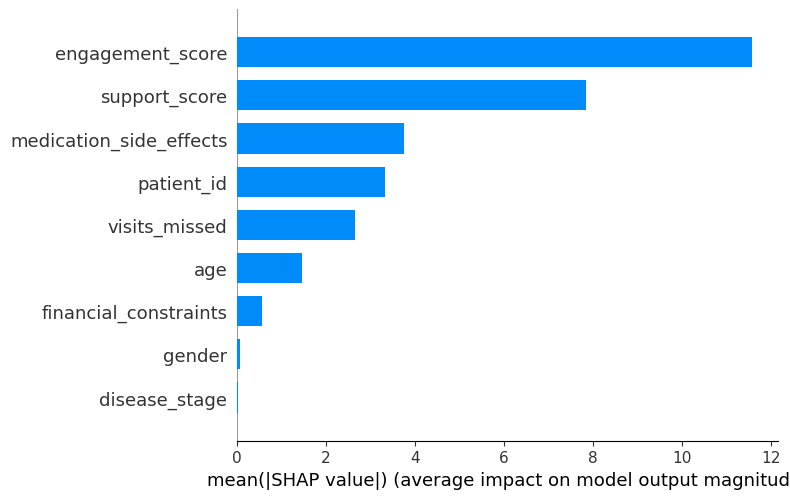

In [47]:
shap.summary_plot(shap_values.values, X_test, plot_type="bar")


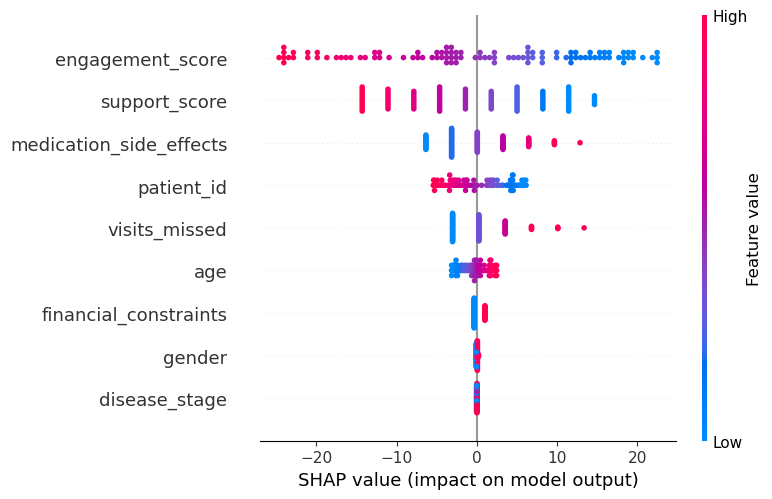

In [48]:
shap.summary_plot(shap_values.values, X_test)


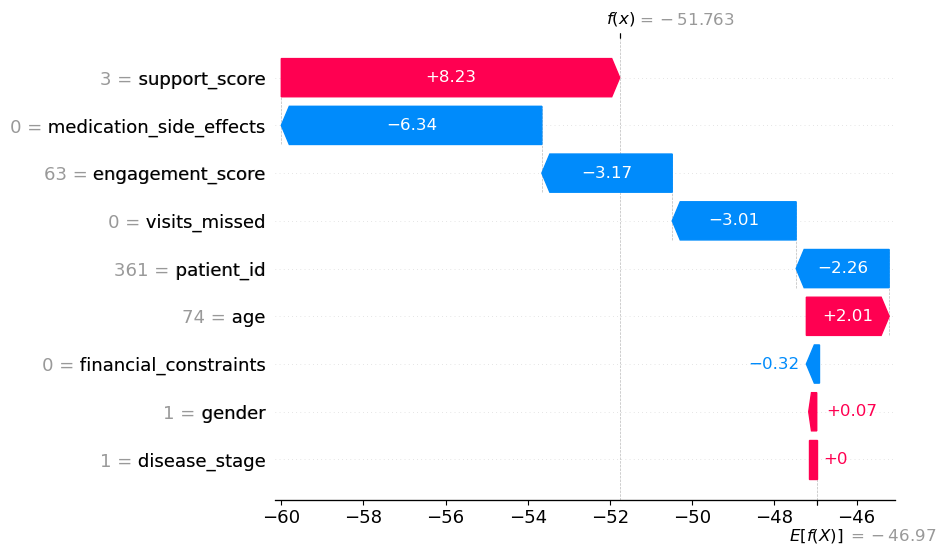

In [49]:
shap.plots.waterfall(shap_values[0])  # Change index to view others


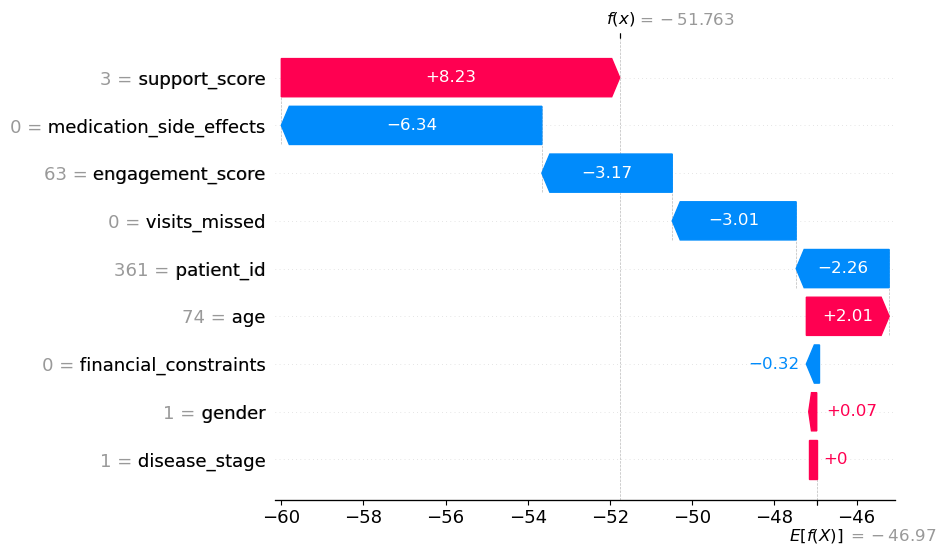

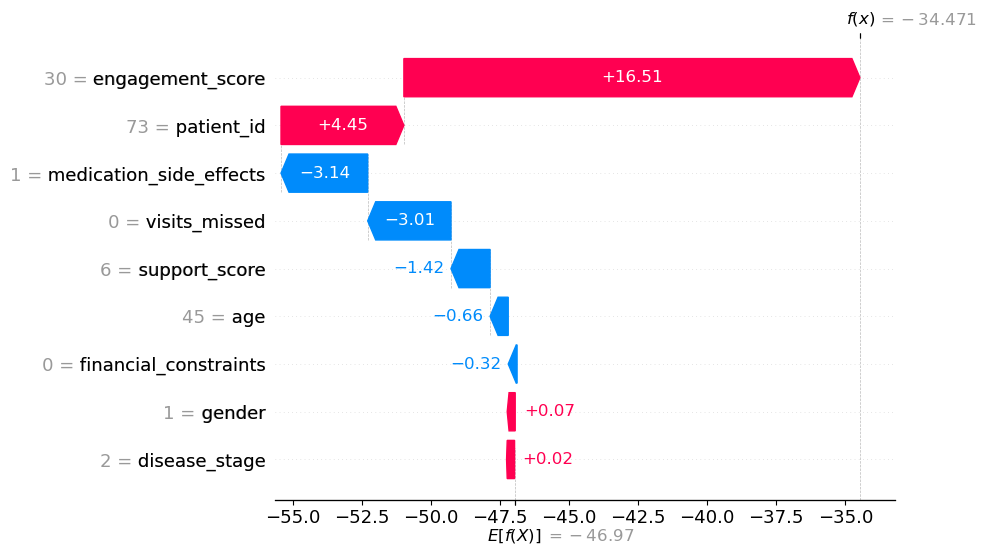

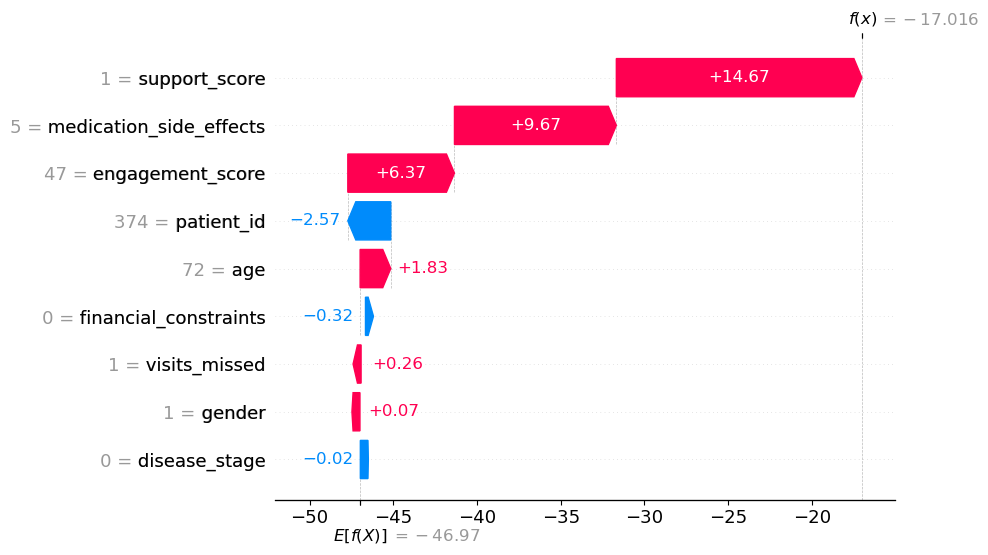

In [50]:
for i in range(3):
    shap.plots.waterfall(shap_values[i])


In [52]:
import joblib

joblib.dump(log_model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [53]:
joblib.dump(explainer, "shap_explainer.pkl")


['shap_explainer.pkl']

In [57]:
import streamlit as st
import pandas as pd
import joblib
import shap

# Load model and scaler
model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
explainer = joblib.load("shap_explainer.pkl")

st.title("🧬 Clinical Trial Dropout Prediction")
st.markdown("Upload patient data to predict dropout risk and explain results.")

uploaded_file = st.file_uploader("Upload CSV", type=["csv"])
if uploaded_file:
    data = pd.read_csv(uploaded_file)
    st.write("📄 Uploaded Data:", data.head())

    # Preprocess
    scaled = scaler.transform(data)

    # Predict
    preds = model.predict(scaled)
    proba = model.predict_proba(scaled)[:, 1]
    data["Dropout Risk"] = proba
    data["Prediction"] = ["Likely to Stay" if p < 0.5 else "Likely to Dropout" for p in proba]
    st.write("📊 Predictions:", data[["Dropout Risk", "Prediction"]])

    # SHAP explanation
    st.subheader("🔍 Explainability (First Patient)")
    shap_values = explainer(scaled)
    st_shap = st.pyplot
    shap.plots.waterfall(shap_values[0], show=False)
    st.pyplot(bbox_inches='tight')


2025-06-17 17:02:25.635 
  command:

    streamlit run C:\Users\thesa\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [55]:
import shap
explainer = shap.LinearExplainer(log_model, X_train_scaled)
joblib.dump(explainer, "shap_explainer.pkl")


['shap_explainer.pkl']

In [59]:
import streamlit as st
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt

# Load trained model and scaler
model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")

st.set_page_config(page_title="Clinical Trial Dropout Predictor", layout="centered")

st.title("🧬 Clinical Trial Dropout Prediction")
st.markdown("Upload patient data to **predict dropout risk** and explain results using **SHAP**.")

# Upload CSV
uploaded_file = st.file_uploader("📂 Upload a CSV file with patient features", type=["csv"])

if uploaded_file:
    data = pd.read_csv(uploaded_file)
    st.write("📄 **Uploaded Data Preview:**", data.head())

    # Scale the input
    scaled_data = scaler.transform(data)

    # Predict
    predictions = model.predict(scaled_data)
    probabilities = model.predict_proba(scaled_data)[:, 1]

    data["Dropout Risk (Probability)"] = probabilities
    data["Prediction"] = ["Likely to Stay" if p < 0.5 else "Likely to Dropout" for p in probabilities]

    st.write("📊 **Predictions:**", data[["Dropout Risk (Probability)", "Prediction"]])

    # SHAP Explainability
    st.subheader("🔍 SHAP Explainability (First Patient)")

    try:
        explainer = shap.Explainer(model, scaled_data)
        shap_values = explainer(scaled_data)

        fig, ax = plt.subplots(figsize=(10, 4))
        shap.plots.waterfall(shap_values[0], show=False)
        st.pyplot(fig)
    except Exception as e:
        st.error(f"⚠️ SHAP could not explain this model: {e}")



In [62]:
!jupyter nbconvert --to script project1.ipynb


[NbConvertApp] Converting notebook project1.ipynb to script
[NbConvertApp] Writing 12941 bytes to project1.py


In [63]:
import os
os.getcwd()


'C:\\Users\\thesa\\Downloads\\sarthak Python'